# Building a machine learning algorithm to predict solar installation rates based on demographic data

In [1]:
# Load necessary libraries for analysis
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

## Load data

To attempt to build such an algorithm, we begin by loading in relevant information. We will use data from the Australian Photovoltaic Institute (APVI) for information regarding solar installation rates in each local government area (LGA) of Australia (ref 1). We will then use demographic information compiled by the Australian Bureau of Statistics (ABS) as predictors in our algorithm (ref 2-4). For details on the data used, please see the References / Data section.

In [2]:
# Load data
pv = pd.read_csv("data/lgas_41d2.csv")
seifa = pd.read_csv("data/ABS_SEIFA2016_LGA_19022020125819856 (seifa).csv")
edu = pd.read_csv("data/ABS_REGIONAL_LGA2018_19022020132647134 (education).csv")
pop = pd.read_csv("data/ABS_REGIONAL_LGA2018_19022020132231122 (population).csv")
dwell = pd.read_csv("data/ABS_C16_T24_LGA_19022020130456240 (dwelling structure).csv")

## Data wrangling

Here we first preview the individual loaded datasets before proceeding to wrangle them into the correct format to build our machine learning model. We want a single, final dataframe with LGA as the index, the density variable as the first column, and all the predictors making up the remainder of the columns. The LGA will not be a predictor or response in our final model but we keep it here to retain information on which local government area we are looking at in case this turns out to be useful later. The density variable, indicating the percentage of dwellings with solar installed in a LGA, is our response variable. We will later also drop or impute missing entries so that we have a dataframe without any empty values.

### pv data

In [3]:
# Preview
pv.head()

,LGA,lga_name,lga_state,capacity_lga,dwellings_lga,instals_lga,density_lga,capunder10,cap10_100,capover100,countunder10,count10_100,count100
0,10050,Albury (C),NSW,27597.0,25547.0,5115.0,18.8,16674.0,7827.0,3096.0,4796.0,319.0,4.0
1,10130,Armidale Regional (A),NSW,13380.0,12406.0,2690.0,20.3,9466.0,3914.0,0.0,2518.0,172.0,0.0
2,10250,Ballina (A),NSW,29350.0,19436.0,7314.0,36.4,23756.0,5010.0,584.0,7072.0,242.0,3.0
3,10300,Balranald (A),NSW,154436.0,1174.0,211.0,15.8,853.0,535.0,153048.0,185.0,26.0,2.0
4,10470,Bathurst Regional (A),NSW,17636.0,17524.0,3383.0,17.9,12549.0,5087.0,0.0,3144.0,239.0,0.0


In [4]:
# Wrangle to appropriate format for merging
pv = pv[['lga_name', 'density_lga']]
pv.rename(columns = {'lga_name':'LGA', 'density_lga':'Density (%)'}, inplace = True)
pv.head()

,LGA,Density (%)
0,Albury (C),18.8
1,Armidale Regional (A),20.3
2,Ballina (A),36.4
3,Balranald (A),15.8
4,Bathurst Regional (A),17.9


### seifa data

In [5]:
# Preview
seifa.head()

,LGA_2016,Local Government Areas - 2016,SEIFAINDEXTYPE,Index Type,SEIFA_MEASURE,Measure,TIME,Time,Value,Flag Codes,Flags
0,10050,Albury (C),IEO,Index of Education and Occupation,SCORE,Score,2016,2016,961.0,NaN,NaN
1,10050,Albury (C),IEO,Index of Education and Occupation,RWAR,Rank within Australia,2016,2016,291.0,NaN,NaN
2,10050,Albury (C),IEO,Index of Education and Occupation,RWAD,Rank within Australia - Decile,2016,2016,6.0,NaN,NaN
3,10050,Albury (C),IEO,Index of Education and Occupation,RWAP,Rank within Australia - Percentile,2016,2016,54.0,NaN,NaN
4,10050,Albury (C),IEO,Index of Education and Occupation,RWSR,Rank within State or Territory,2016,2016,69.0,NaN,NaN


In [6]:
# Wrangle to appropriate format for merging
seifa = seifa[seifa['SEIFA_MEASURE'] == 'SCORE']
seifa = seifa[['Local Government Areas - 2016', 'SEIFAINDEXTYPE', 'Value']]
seifa.rename(columns = {'Local Government Areas - 2016':'LGA'}, inplace = True)
seifa = seifa.pivot(index = 'LGA', columns = 'SEIFAINDEXTYPE', values = 'Value')
seifa.reset_index(inplace = True)
seifa.head()

SEIFAINDEXTYPE,LGA,IEO,IER,IRSAD,IRSD
0,Adelaide (C),1154.0,866.0,1058.0,1014.0
1,Adelaide Hills (DC),1084.0,1082.0,1072.0,1080.0
2,Albany (C),960.0,1003.0,968.0,989.0
3,Albury (C),961.0,960.0,956.0,971.0
4,Alexandrina (DC),964.0,1004.0,961.0,986.0


### edu data

In [7]:
# Preview
edu.head()

,MEASURE,Data item,REGIONTYPE,Geography Level,LGA_2018,Region,FREQUENCY,Frequency,TIME,Time,Value,Flag Codes,Flags
0,PRESCH_2,4 year olds enrolled in preschool or in a pres...,LGA2018,Local Government Areas (2018),10050,Albury (C),A,Annual,2016,2016,580.0,NaN,NaN
1,PRESCH_2,4 year olds enrolled in preschool or in a pres...,LGA2018,Local Government Areas (2018),10050,Albury (C),A,Annual,2017,2017,613.0,NaN,NaN
2,PRESCH_2,4 year olds enrolled in preschool or in a pres...,LGA2018,Local Government Areas (2018),10050,Albury (C),A,Annual,2018,2018,634.0,NaN,NaN
3,PRESCH_3,5 year olds enrolled in preschool or in a pres...,LGA2018,Local Government Areas (2018),10050,Albury (C),A,Annual,2016,2016,224.0,NaN,NaN
4,PRESCH_3,5 year olds enrolled in preschool or in a pres...,LGA2018,Local Government Areas (2018),10050,Albury (C),A,Annual,2017,2017,268.0,NaN,NaN


In [8]:
# Wrangle to appropriate format for merging
edu = edu[edu['Time'] == 2016]
edu = edu[['Region', 'Data item', 'Value']]
edu.rename(columns = {'Region':'LGA'}, inplace = True)
edu = edu.pivot(index = 'LGA', columns = 'Data item', values = 'Value')
edu.reset_index(inplace = True)
edu.head()

Data item,LGA,4 year olds enrolled in preschool or in a preschool program (no.),5 year olds enrolled in preschool or in a preschool program (no.),Advanced Diploma/Diploma (%),"Agriculture, Environmental and Related Studies (%)",Architecture and Building (%),Bachelor Degree (%),Certificate (%),Children attending preschool for 15 hours or more (no.),Children attending preschool for less than 15 hours (no.),...,Total persons aged 15-19 years (no.),Total population aged 15 years and over (no.),Unemployed (no.),Unemployment rate (%),Working (away from work) and studying full-time (%),Working full-time (not studying) (%),Working full-time and studying full-time (%),Working full-time and studying part-time (%),Working part time and studying part-time (%),Working part-time and studying full-time (%)
0,Adelaide (C),81.0,15.0,8.1,1.0,3.5,24.4,8.1,69.0,16.0,...,1582.0,20850.0,1255.0,11.9,2.7,1.1,0.2,0.3,0.4,12.3
1,Adelaide Hills (DC),389.0,87.0,10.5,3.7,5.2,19.5,18.7,353.0,113.0,...,2685.0,31601.0,898.0,4.4,1.3,4.5,0.2,1.6,1.6,21.7
2,Adelaide Plains (DC),104.0,22.0,6.3,3.8,5.8,4.6,25.0,91.0,31.0,...,582.0,7108.0,304.0,6.9,0.7,4.3,0.5,2.4,1.7,16.7
3,Albany (C),422.0,6.0,8.9,5.1,6.2,9.6,23.7,284.0,120.0,...,2404.0,29805.0,868.0,5.1,1.1,9.6,0.2,2.9,1.4,18.3
4,Albury (C),580.0,224.0,8.5,2.7,6.3,11.3,23.8,457.0,330.0,...,3248.0,41468.0,1684.0,6.8,2.2,7.5,0.5,2.8,1.6,23.6


### pop data

In [9]:
# Preview
pop.head()

,MEASURE,Data item,REGIONTYPE,Geography Level,LGA_2018,Region,FREQUENCY,Frequency,TIME,Time,Value,Flag Codes,Flags
0,ERP_M_2,Males - 0-4 years (no.),LGA2018,Local Government Areas (2018),10050.0,Albury (C),A,Annual,2013.0,2013.0,1664.0,NaN,NaN
1,ERP_M_2,Males - 0-4 years (no.),LGA2018,Local Government Areas (2018),10050.0,Albury (C),A,Annual,2014.0,2014.0,1705.0,NaN,NaN
2,ERP_M_2,Males - 0-4 years (no.),LGA2018,Local Government Areas (2018),10050.0,Albury (C),A,Annual,2015.0,2015.0,1766.0,NaN,NaN
3,ERP_M_2,Males - 0-4 years (no.),LGA2018,Local Government Areas (2018),10050.0,Albury (C),A,Annual,2016.0,2016.0,1812.0,NaN,NaN
4,ERP_M_2,Males - 0-4 years (no.),LGA2018,Local Government Areas (2018),10050.0,Albury (C),A,Annual,2017.0,2017.0,1949.0,NaN,NaN


In [10]:
# Wrangle to appropriate format for merging
pop = pop[pop['Time'] == 2016]
pop = pop[['Region', 'Data item', 'Value']]
pop.rename(columns = {'Region':'LGA'}, inplace = True)
pop = pop.pivot(index = 'LGA', columns = 'Data item', values = 'Value')
pop.reset_index(inplace = True)
pop.head()

Data item,LGA,Aboriginal and Torres Strait Islander Peoples (%),Australian citizen (%),Australian citizenship - Not stated (%),Births and Deaths - Births (no.),Births and Deaths - Deaths (no.),Births and Deaths - Standardised death rate (per 1000 population) (rate),Births and Deaths - Total fertility rate (per female) (rate),Born in Americas (%),Born in North Africa and the Middle East (%),...,Persons - 70-74 years (no.),Persons - 75-79 years (no.),Persons - 80-84 years (no.),Persons - 85 and over (no.),Persons - Total (no.),Population density (persons/km2),Religious Affiliation - Inadequately described or not stated (%),Speaks a Language Other Than English at Home (%),Total born overseas (%),Working Age Population (aged 15-64 years) (no.)
0,Adelaide (C),1.2,56.6,11.4,142.0,132.0,5.6,0.8,2.5,2.2,...,733.0,498.0,267.0,400.0,23552.0,1512.3,14.6,36.3,44.2,19141.0
1,Adelaide Hills (DC),0.6,90.9,4.9,374.0,201.0,4.4,1.9,0.9,0.3,...,1729.0,1046.0,669.0,662.0,39632.0,49.9,9.1,5.6,16.9,25367.0
2,Adelaide Plains (DC),2.6,89.5,7.0,90.0,35.0,4.6,1.9,0.2,0.1,...,310.0,175.0,94.0,76.0,8912.0,9.6,9.6,4.5,12.9,6001.0
3,Albany (C),3.3,86.6,7.6,388.0,369.0,5.9,1.9,0.7,0.2,...,1752.0,1328.0,950.0,1028.0,37285.0,8.6,10.5,6.0,18.9,22828.0
4,Albury (C),2.8,88.2,7.3,757.0,456.0,5.9,2.0,0.4,0.2,...,2136.0,1641.0,1209.0,1317.0,52171.0,170.5,9.2,6.7,10.8,33186.0


### dwell data

In [11]:
# Preview
dwell.head()

,DWTD_2016,Dwelling Type,STRD_2016,Dwelling Structure,STATE,State,REGIONTYPE,Geography Level,LGA_2016,Region,TIME,Census Year,Value,Flag Codes,Flags
0,TOT,Total,TOT,Total,1,New South Wales,LGA2016,Local Government Areas (2016),10050,Albury (C),2016,2016,23464,NaN,NaN
1,TOT,Total,11,Separate house,1,New South Wales,LGA2016,Local Government Areas (2016),10050,Albury (C),2016,2016,18127,NaN,NaN
2,TOT,Total,21,"Semi-detached, row or terrace house, townhouse...",1,New South Wales,LGA2016,Local Government Areas (2016),10050,Albury (C),2016,2016,3702,NaN,NaN
3,TOT,Total,22,"Semi-detached, row or terrace house, townhouse...",1,New South Wales,LGA2016,Local Government Areas (2016),10050,Albury (C),2016,2016,586,NaN,NaN
4,TOT,Total,31,Flat or apartment: In a one or two storey block,1,New South Wales,LGA2016,Local Government Areas (2016),10050,Albury (C),2016,2016,563,NaN,NaN


In [12]:
# Wrangle to appropriate format for merging
dwell = dwell[(dwell['TIME'] == 2016) & (dwell['Dwelling Type'] == 'Total')]
dwell = dwell[['Region', 'Dwelling Structure', 'Value']]
dwell.rename(columns = {'Region':'LGA'}, inplace = True)
dwell = dwell.pivot(index = 'LGA', columns = 'Dwelling Structure', values = 'Value')
dwell.reset_index(inplace = True)
dwell.head()

Dwelling Structure,LGA,"Cabin, houseboat",Caravan,Flat or apartment: Attached to a house,Flat or apartment: In a four or more storey block,Flat or apartment: In a one or two storey block,Flat or apartment: In a three storey block,"House or flat attached to a shop, office, etc.","Improved home, tent, sleepers out",Not appliacable,Not stated,"Semi-detached, row or terrace house, townhouse etc. with : One storey","Semi-detached, row or terrace house, townhouse etc. with : Two or more storeys",Separate house,Total
0,Adelaide (C),0,3,5,3987,862,1182,91,121,131,108,1345,2525,1317,11666
1,Adelaide Hills (DC),12,31,0,0,107,23,22,7,23,106,305,48,14792,15478
2,Albany (C),88,196,8,0,67,0,30,47,79,75,1285,134,14922,16924
3,Albury (C),50,37,3,38,563,112,55,7,91,82,3702,586,18127,23464
4,Alexandrina (DC),146,54,0,0,299,0,34,25,24,46,297,229,14257,15402


### Combined data

In [13]:
# Merge data
df = pv.merge(seifa, left_on = 'LGA', right_on = 'LGA')
df = df.merge(edu, left_on = 'LGA', right_on = 'LGA')
df = df.merge(pop, left_on = 'LGA', right_on = 'LGA')
df = df.merge(dwell, left_on = 'LGA', right_on = 'LGA')
df.set_index('LGA', inplace = True)
df.head()

,Density (%),IEO,IER,IRSAD,IRSD,4 year olds enrolled in preschool or in a preschool program (no.),5 year olds enrolled in preschool or in a preschool program (no.),Advanced Diploma/Diploma (%),"Agriculture, Environmental and Related Studies (%)",Architecture and Building (%),...,Flat or apartment: In a one or two storey block,Flat or apartment: In a three storey block,"House or flat attached to a shop, office, etc.","Improved home, tent, sleepers out",Not appliacable,Not stated,"Semi-detached, row or terrace house, townhouse etc. with : One storey","Semi-detached, row or terrace house, townhouse etc. with : Two or more storeys",Separate house,Total
LGA,,,,,,,,,,,,,,,,,,,,,
Albury (C),18.8,961.0,960.0,956.0,971.0,580.0,224.0,8.5,2.7,6.3,...,563,112,55,7,91,82,3702,586,18127,23464
Armidale Regional (A),20.3,1015.0,958.0,976.0,980.0,290.0,70.0,7.2,6.6,4.4,...,647,60,39,13,72,99,1036,189,10483,12738
Ballina (A),36.4,999.0,998.0,987.0,1003.0,480.0,180.0,9.5,3.2,6.7,...,727,198,38,20,48,144,2532,1847,12760,19154
Balranald (A),15.8,915.0,969.0,927.0,942.0,18.0,10.0,4.4,9.3,3.3,...,55,0,7,5,20,4,28,3,1044,1221
Bathurst Regional (A),17.9,978.0,993.0,973.0,986.0,382.0,154.0,8.1,3.0,5.7,...,799,17,31,10,63,171,1495,434,14345,17431


## Exploratory data analysis

Here we check the shape and summary statistics of the combined dataframe for any anomalous results. We also look at the effect on dataset size when removing missing values. This is to guide our decision as to whether we would have a dataset large enough to progress to building our algorithm or whether we should impute missing values to maintain a large enough dataset size.

In [14]:
# Explore dataframe
print("Shape of dataframe:", df.shape)
df.describe()

Shape of dataframe: (481, 194)


,Density (%),IEO,IER,IRSAD,IRSD,4 year olds enrolled in preschool or in a preschool program (no.),5 year olds enrolled in preschool or in a preschool program (no.),Advanced Diploma/Diploma (%),"Agriculture, Environmental and Related Studies (%)",Architecture and Building (%),...,Flat or apartment: In a one or two storey block,Flat or apartment: In a three storey block,"House or flat attached to a shop, office, etc.","Improved home, tent, sleepers out",Not appliacable,Not stated,"Semi-detached, row or terrace house, townhouse etc. with : One storey","Semi-detached, row or terrace house, townhouse etc. with : Two or more storeys",Separate house,Total
count,481.000000,481.000000,481.000000,480.000000,480.000000,477.000000,414.000000,481.000000,480.000000,478.000000,...,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000
mean,22.973181,972.503119,969.611227,962.362500,963.800000,519.758910,133.630435,7.401663,4.913542,5.242678,...,941.864865,710.831601,53.812890,34.492723,43.207900,90.515593,1390.629938,1060.987526,13521.405405,19068.673597
std,10.207851,74.714097,98.282038,85.529212,99.413466,1017.663145,217.730616,1.902498,3.787377,1.817519,...,2286.274815,2679.743155,117.658715,66.506300,66.946608,155.390705,2668.326128,3051.987980,23442.835840,34297.833245
min,0.000000,741.000000,484.000000,566.000000,404.000000,1.000000,1.000000,1.700000,0.500000,1.200000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,15.000000
25%,17.100000,929.000000,960.000000,932.000000,942.750000,35.000000,9.000000,6.200000,1.700000,4.200000,...,22.000000,0.000000,4.000000,3.000000,10.000000,13.000000,26.000000,0.000000,1178.000000,1507.000000
50%,22.700000,960.000000,986.000000,962.000000,980.000000,138.000000,41.000000,7.300000,3.800000,5.100000,...,161.000000,0.000000,17.000000,12.000000,24.000000,46.000000,203.000000,24.000000,5126.000000,6553.000000
75%,30.100000,996.000000,1014.000000,998.000000,1014.000000,516.000000,176.250000,8.900000,7.000000,6.200000,...,824.000000,112.000000,44.000000,33.000000,49.000000,108.000000,1505.000000,642.000000,14922.000000,21753.000000
max,48.400000,1195.000000,1136.000000,1166.000000,1123.000000,13155.000000,1365.000000,13.200000,19.200000,20.200000,...,32350.000000,34690.000000,1389.000000,646.000000,730.000000,2178.000000,27568.000000,39450.000000,300884.000000,464328.000000


In [15]:
# Explore effect on size of dataframe when removing NA values
print("df size after dropping rows:", df.dropna(axis = 0).shape)
print("df size after dropping columns:", df.dropna(axis = 1).shape)
print("seifa size after dropping rows:", seifa.dropna(axis = 0).shape)
print("seifa size after dropping columns:", seifa.dropna(axis = 1).shape)
print("edu size after dropping rows:", edu.dropna(axis = 0).shape)
print("edu size after dropping columns:", edu.dropna(axis = 1).shape)
print("pop size after dropping rows:", pop.dropna(axis = 0).shape)
print("pop size after dropping columns:", pop.dropna(axis = 1).shape)
print("dwell size after dropping rows:", dwell.dropna(axis = 0).shape)
print("dwell size after dropping columns:", dwell.dropna(axis = 1).shape)

df size after dropping rows: (122, 194)
df size after dropping columns: (481, 42)
seifa size after dropping rows: (544, 5)
seifa size after dropping columns: (545, 3)
edu size after dropping rows: (254, 87)
edu size after dropping columns: (562, 8)
pop size after dropping rows: (151, 90)
pop size after dropping columns: (500, 1)
dwell size after dropping rows: (554, 15)
dwell size after dropping columns: (554, 15)


In [16]:
# Check number of columns with less than 3 missing values
(df.isnull().sum() < 5).sum()

125

## Imputing missing values

We found that there are 125 columns with only a minimal number (less than 5) of missing values. We can reasonably impute median values into these columns without changing the data too much.

In [17]:
# Retain only these 125 columns with less than 5 missing values and impute the median into these columns
mask = df.isnull().sum() < 5
df = df[mask.index[mask]]
df = df.fillna(df.median())
print("Shape of dataframe:", df.shape)
df.head()

Shape of dataframe: (481, 125)


,Density (%),IEO,IER,IRSAD,IRSD,4 year olds enrolled in preschool or in a preschool program (no.),Advanced Diploma/Diploma (%),"Agriculture, Environmental and Related Studies (%)",Architecture and Building (%),Bachelor Degree (%),...,Flat or apartment: In a one or two storey block,Flat or apartment: In a three storey block,"House or flat attached to a shop, office, etc.","Improved home, tent, sleepers out",Not appliacable,Not stated,"Semi-detached, row or terrace house, townhouse etc. with : One storey","Semi-detached, row or terrace house, townhouse etc. with : Two or more storeys",Separate house,Total
LGA,,,,,,,,,,,,,,,,,,,,,
Albury (C),18.8,961.0,960.0,956.0,971.0,580.0,8.5,2.7,6.3,11.3,...,563,112,55,7,91,82,3702,586,18127,23464
Armidale Regional (A),20.3,1015.0,958.0,976.0,980.0,290.0,7.2,6.6,4.4,13.6,...,647,60,39,13,72,99,1036,189,10483,12738
Ballina (A),36.4,999.0,998.0,987.0,1003.0,480.0,9.5,3.2,6.7,13.6,...,727,198,38,20,48,144,2532,1847,12760,19154
Balranald (A),15.8,915.0,969.0,927.0,942.0,18.0,4.4,9.3,3.3,5.2,...,55,0,7,5,20,4,28,3,1044,1221
Bathurst Regional (A),17.9,978.0,993.0,973.0,986.0,382.0,8.1,3.0,5.7,11.3,...,799,17,31,10,63,171,1495,434,14345,17431


## Preprocessing data (train-test split and principal components analysis)

Given that we only have 481 observations in our dataset, the use of 124 predictors for prediction may lead to overfitting or a lot of redundancy. We wish to have a dataset with less predictors to feed into our machine learning algorithm while retaining the variability in the response explained by the predictors (i.e. we wish to preserve the information of these predictors). We choose to reduce the number of predictors by using principal component analysis to transform the data and use as our predictors the principal components which explain most of the variability in the response.

We will first perform a train-test split before performing the principal components analysis (code built using ref 5). We want to reserve a test set to evaluate our built algorithm later, but perform the train-test split now otherwise we would be using information within the test set for our principal components analysis and subsequent model building, introducing bias in our model evaluation.

In [18]:
# Separate response and predictors in dataframe into separate objects
response = np.array(df['Density (%)'])
predictors = df.drop('Density (%)', axis = 1)
predictor_list = list(predictors.columns)
predictors = np.array(predictors)

In [19]:
# Perform train-test split
train_predictors, test_predictors, train_response, test_response = train_test_split(predictors, response, test_size = 0.3, random_state = 1)
print('Training Predictors Shape:', train_predictors.shape)
print('Training Response Shape:', train_response.shape)
print('Testing Predictors Shape:', test_predictors.shape)
print('Testing Response Shape:', test_response.shape)

Training Predictors Shape: (336, 124)
Training Response Shape: (336,)
Testing Predictors Shape: (145, 124)
Testing Response Shape: (145,)


In [31]:
# Check for high correlations between predictors
pd.DataFrame(train_predictors).corr()

,0,1,2,3,4,5,6,7,8,9,...,114,115,116,117,118,119,120,121,122,123
0,1.000000,0.540561,0.884046,0.745616,0.162119,0.641033,-0.176344,-0.214650,0.898070,-0.554260,...,0.311476,0.382715,0.282446,-0.031655,0.204402,0.182143,0.309427,0.310522,0.121564,0.228530
1,0.540561,1.000000,0.833816,0.932903,0.162930,0.618553,0.049693,-0.030803,0.359541,0.136643,...,0.096654,0.080435,0.075575,-0.106336,0.047139,0.104779,0.151289,0.098097,0.184026,0.160036
2,0.884046,0.833816,1.000000,0.957171,0.220626,0.716136,-0.160641,-0.126520,0.776435,-0.251396,...,0.275683,0.315749,0.247732,-0.043847,0.185048,0.199206,0.311300,0.278945,0.195590,0.259501
3,0.745616,0.932903,0.957171,1.000000,0.183891,0.692517,-0.058270,-0.068887,0.589250,-0.028256,...,0.194969,0.201333,0.162867,-0.053628,0.154936,0.165639,0.246646,0.190631,0.186431,0.213448
4,0.162119,0.162930,0.220626,0.183891,1.000000,0.384494,-0.383059,0.135638,0.273399,-0.068304,...,0.809960,0.672015,0.536402,0.261829,0.662098,0.852376,0.704649,0.877427,0.972214,0.975287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,0.182143,0.104779,0.199206,0.165639,0.852376,0.311083,-0.341198,0.147449,0.274690,-0.067282,...,0.859188,0.760484,0.615019,0.434600,0.868025,1.000000,0.595427,0.862760,0.848945,0.910434
120,0.309427,0.151289,0.311300,0.246646,0.704649,0.462840,-0.474388,0.094689,0.452213,-0.206812,...,0.646468,0.430458,0.601314,0.151539,0.501579,0.595427,1.000000,0.642278,0.701934,0.734801
121,0.310522,0.098097,0.278945,0.190631,0.877427,0.306464,-0.330373,-0.007656,0.419093,-0.291909,...,0.919354,0.852362,0.687698,0.241081,0.682571,0.862760,0.642278,1.000000,0.808720,0.909757
122,0.121564,0.184026,0.195590,0.186431,0.972214,0.409165,-0.380698,0.217367,0.216804,0.018499,...,0.756908,0.575935,0.466177,0.289646,0.676384,0.848945,0.701934,0.808720,1.000000,0.968471


In [20]:
# Scale predictors and perform principal components analysis
scaler = StandardScaler()
pca = PCA()
train_predictors_pca = scaler.fit_transform(train_predictors)
train_predictors_pca = pca.fit_transform(train_predictors)
test_predictors_pca = scaler.transform(test_predictors)
test_predictors_pca = pca.transform(test_predictors)

In [21]:
# Calculate percentage of variance explained by first 20 principal components
sum(pca.explained_variance_ratio_[0:19])

0.9999886033414418

In [22]:
# Retain only first 20 principal components to use as predictors
train_predictors_pca20 = np.array(pd.DataFrame(train_predictors_pca).iloc[:, :20])
test_predictors_pca20 = np.array(pd.DataFrame(test_predictors_pca).iloc[:, :20])

## Model building and evaluation

Here we build 4 separate models and select the best one in terms of out-of-sample accuracy measured by the test sample R squared. We build a multiple linear regression model, a boosting model, a random forest model (code built using ref 6) and a random forest model using hyperparameter tuning to see if we can significantly improve its accuracy (code built using ref 7).

### Multiple Linear Regression Model

In [23]:
# Build multiple linear regression model
lr = LinearRegression()
lr.fit(train_predictors_pca20, train_response)
print("Train r squared:", lr.score(train_predictors_pca20, train_response))
print("Test r squared:", lr.score(test_predictors_pca20, test_response))

Train r squared: 0.2703166789751422
Test r squared: 0.15717867705481747


### Boosting Regression Model

In [24]:
boost = AdaBoostRegressor(n_estimators = 1000, random_state = 2)
boost.fit(train_predictors_pca20, train_response)
print("Train r squared:", boost.score(train_predictors_pca20, train_response))
print("Test r squared:", boost.score(test_predictors_pca20, test_response))

Train r squared: 0.6810832282921078
Test r squared: 0.2939429088986316


### Random Forest Regression Model

In [25]:
# Build random forest model
rf = RandomForestRegressor(n_estimators = 1000, random_state = 3)
rf.fit(train_predictors_pca20, train_response)
print("Train r squared:", rf.score(train_predictors_pca20, train_response))
print("Test r squared:", rf.score(test_predictors_pca20, test_response))

Train r squared: 0.9222982930546839
Test r squared: 0.3645988762013138


### Hyperparameter Tuning

In [26]:
# Create hyperparameter grid search
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


### Random Forest Regression Model with Hyperparameter Tuning

In [27]:
# Build random forest model with hyperparameter tuning
rf2 = RandomForestRegressor()
rf_tuned = RandomizedSearchCV(estimator = rf2, param_distributions = random_grid, n_iter = 100, cv = 3, verbose = 2, random_state = 4, n_jobs = -1)
rf_tuned.fit(train_predictors_pca20, train_response)
print("Train r squared:", rf_tuned.score(train_predictors_pca20, train_response))
print("Test r squared:", rf_tuned.score(test_predictors_pca20, test_response))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   53.6s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  7.0min finished


Train r squared: 1.0
Test r squared: 0.3701463941497942


## Summary of model evaluations

Model | Train set R squared | Test set R squared
--- | --- | ---
Multiple Linear Regression | 0.2703166789751422 | 0.15717867705481747
Boosting Regression (AdaBoost) | 0.6810832282921078 | 0.2939429088986316
Random Forest Regression | 0.9222982930546839 | 0.3645988762013138
Random Forest Regression with Hyperparameter Tuning | 1.0 | 0.3701463941497942

## Plotting final model

We find that the random forest model is our best model. It outperforms the boosting model which in turn significantly outperforms the multiple linear regression model. We also find that with hyperparameter tuning the random forest model shows almost perfect training data fit but little improvement in testing data fit. There is reason to suspect higher amounts of overfitting in the model with hyperparameter tuning, thus we elect to choose the original random forest model as our final model.

Text(10, 15, 'R squared = 0.36')

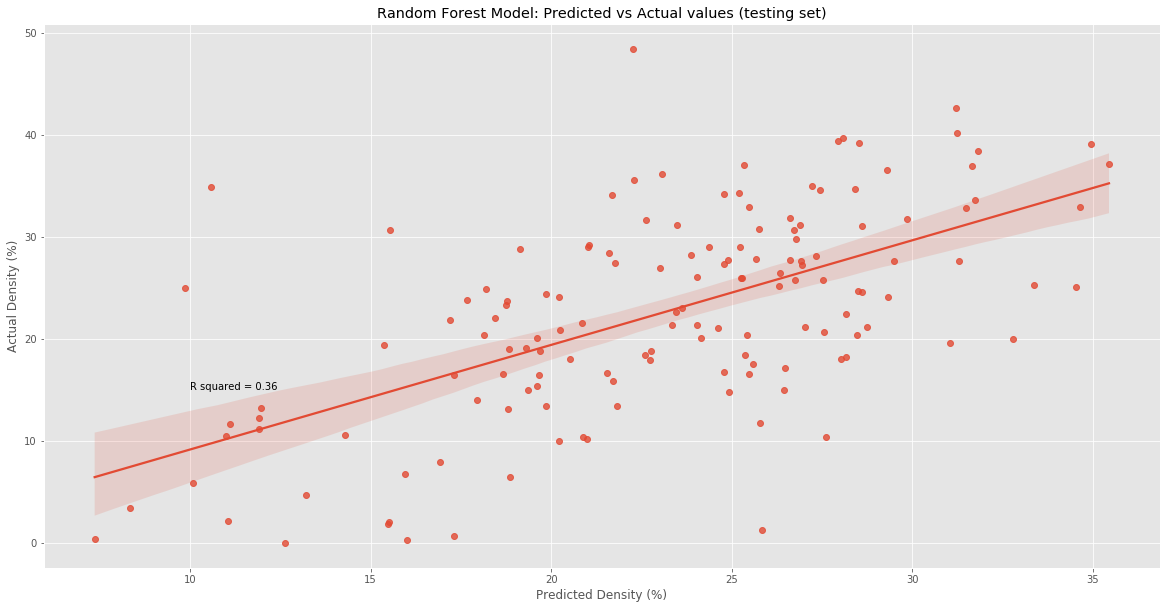

In [33]:
# Create plot
plt.figure(figsize = (20, 10))
ax = sns.regplot(x = rf.predict(test_predictors_pca20), y = test_response)
ax.set_title("Random Forest Model: Predicted vs Actual values (testing set)")
ax.set_ylabel("Actual Density (%)")
ax.set_xlabel("Predicted Density (%)")
ax.annotate("R squared = 0.36", xy = (10, 15))

# References / Data

1. Australian PV Institute (APVI) Solar Map, funded by the Australian Renewable Energy Agency, accessed from pv-map.apvi.org.au on 19 February 2020. Dataset can be downloaded from https://pv-map.apvi.org.au/historical#4/-26.67/134.12. Data on solar installation rates divided by LGA was obtained from here.

2. Australian Bureau of Statistics 2020, 'Regional Statistics by LGA 2018, 2011-2018', viewed 26 February 2020, http://stat.data.abs.gov.au. Data on population, education and employment was obtained from here.

3. Australian Bureau of Statistics 2020, 'SEIFA 2016 by Local Government Area (LGA)', viewed 26 February 2020, http://stat.data.abs.gov.au. Data on SEIFA socioeconomic indices was obtained from here.

4. Australian Bureau of Statistics 2020, 'Census 2016, Dwelling Structure by Dwelling Type (LGA)', viewed 26 February 2020, http://stat.data.abs.gov.au. Data on dwelling structure was obtained from here.

5. towards data science. (2019). *Dimension Reduction Techniques with Python*. [online] Available at: https://towardsdatascience.com/dimension-reduction-techniques-with-python-f36ca7009e5c [Accessed 1 Mar. 2020].

6. Koehrsen, W. (2017). *Random Forest in Python*. [online] towards data science. Available at: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0 [Accessed 1 Mar. 2020].

6. Koehrsen, W. (2018). *Hyperparameter Tuning the Random Forest in Python*. [online] towards data science. Available at: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74 [Accessed 1 Mar. 2020].